## SN3 - Minuit section

### Import libraries

In [2]:
# Classic libraries
import sys
from pylab import *
import numpy as np
from matplotlib import rc
import os

# Specific libraries
import cosmolib as cs

# Visuals
rc('figure',figsize=(10,5))
rc('font',size=12)
rc('text',usetex=False)

# Fit using minuit

### Use of minuit on our data

pars : list of parameters (t0 : time of maximum brightness, s : stretch parameter, mu : distance modulus)

Input : (Datas in general)
- Graph X x Y
- Variance of Y
- initial guess (here we use "np.array([0.,1.,mu_guess])") [arbitrary values]
- functname (here we use interpolation)

Output : (Fitting with Minuit)
- chi2
- ndf
- Fitted values
- errors
- Covariance

musn1a(z : redshift, cosmo : list of cosmological paramteres) return distance modulus


In [54]:
# Load redshift data
redshifts = np.loadtxt('data/Data-LightCurves/EI2019-Data-LightCurves-SN-Redshifts.txt')

# Load template lightcurve
t_template, mag_template = np.loadtxt('data/Data-LightCurves/EI2019-Data-LightCurves-SN-SNI-Average_LightCurve.txt').T

class SNIaLightCurve:
    def __init__(self, template_data):
        self.template_t = template_data[0]
        self.template_mag = template_data[1]
        
    def __call__(self, t, pars):
        # pars : [t0, s, mu] where:
        # t0 : time of maximum brightness
        # s : stretch parameter (brighter-slower effect)
        # mu : distance modulus
        t0, s, mu = pars
        
        # Apply time stretch and shift
        t_stretched = (t - t0) / s
        
        # Interpolate template at stretched times
        mag_intrinsic = np.interp(t_stretched, self.template_t, self.template_mag, left=0, right=0)
        
        # Apply brighter-slower correction: -1.52*(s-1) and add distance modulus
        mag_observed = mag_intrinsic - 1.52*(s-1) + mu
        
        return mag_observed

# Initialize template lightcurve
lc_template = SNIaLightCurve([t_template, mag_template])

# Arbitrary cosmological parameters to initialize mu_guess 
cosmo_pars = {'h': 0.7, 'omega_M_0': 0.3895, 'omega_lambda_0': 0.3895, 'w0': -1}

# Function to fit individual supernova
def fit_supernova_lightcurve(sn_number, redshift, lc_template, verbose=False):
    """
    Fit a single supernova lightcurve to extract distance modulus
    """
    # Load supernova data
    filename = f'data/Data-LightCurves/EI2019-Data-LightCurves-SN-{sn_number}_lightcurve.txt'
    if not os.path.exists(filename):
        return None
        
    data = np.loadtxt(filename)
    t_obs = data[:, 0]  # observed time
    mag_obs = data[:, 1]  # observed magnitude
    mag_err = data[:, 2]  # magnitude errors
    
    # Convert to rest frame time
    t_rest = t_obs / (1 + redshift)
    
    # Initial guess: t0=0, s=1, mu=reasonable distance modulus for the redshift
    # Rough distance modulus estimate from redshift (assuming flat ΛCDM) (Omega_k = 0, according to our arbitrary cosmological parameters)
    mu_guess = cs.musn1a(redshift, cosmo_pars)
    
    # Initial guess = [t0, s, mu]
    guess = np.array([0.0, 1.0, mu_guess])
    
    try:
        # Fit using Minuit
        result = cs.do_minuit(t_rest, mag_obs, mag_err, guess, 
                             functname=lc_template, verbose=verbose)
        
        fitm, fitted_values, errors, covariance, chi2, ndf = result
        
        return {
            'sn_number': sn_number,
            'redshift': redshift,
            't0': fitted_values[0],
            't0_err': errors[0],
            's': fitted_values[1],
            's_err': errors[1],
            'mu': fitted_values[2],
            'mu_err': errors[2],
            'chi2': chi2,
            'ndf': ndf,
            'chi2_reduced': chi2/ndf if ndf > 0 else np.inf
        }
    except Exception as e:
        if verbose:
            print(f"Fitting failed for SN-{sn_number}: {e}")
        return None

# Fit all supernovae
print("Fitting individual supernova lightcurves...")
fitting_results = []

for i in range(len(redshifts)):
    print(f"Fitting SN-{i}...")
    result = fit_supernova_lightcurve(i, redshifts[i], lc_template, verbose=True)
    if result is not None:
        fitting_results.append(result)
        print(f"SN-{i}: μ = {result['mu']:.3f} ± {result['mu_err']:.3f}, s = {result['s']:.3f} ± {result['s_err']:.3f}")
    print()

print(f"Successfully fitted {len(fitting_results)} supernovae")

# Display results
if fitting_results:
    print("\nFitting Results Summary:")
    print("SN\tRedshift\tμ ± σ_μ\t\ts ± σ_s\t\tχ²/ndf")
    print("-" * 70)
    for result in fitting_results:
        print(f"{result['sn_number']}\t{result['redshift']:.3f}\t\t{result['mu']:.3f} ± {result['mu_err']:.3f}\t{result['s']:.3f} ± {result['s_err']:.3f}\t{result['chi2_reduced']:.2f}")



Fitting individual supernova lightcurves...
Fitting SN-0...
Fitting with Minuit
Chi2 = 99.9846909974442
ndf = 17
Fitted values:
[-0.08067232  1.03531584 43.63954354]
Errors:
[0.05580366 0.00717269 0.01594977]
Covariance:
[[ 3.11404881e-03 -1.14113354e-04 -1.32636874e-04]
 [-1.14113354e-04  5.14475154e-05  9.33764522e-05]
 [-1.32636874e-04  9.33764522e-05  2.54395253e-04]]
SN-0: μ = 43.640 ± 0.016, s = 1.035 ± 0.007

Fitting SN-1...
Fitting with Minuit
Chi2 = 330.8213110405941
ndf = 17
Fitted values:
[ 3.19268192  0.94784551 41.9563722 ]
Errors:
[0.03832005 0.00534983 0.01306895]
Covariance:
[[1.46842637e-03 5.71990955e-05 1.33723810e-04]
 [5.71990955e-05 2.86206609e-05 6.59529935e-05]
 [1.33723810e-04 6.59529935e-05 1.70797495e-04]]
SN-1: μ = 41.956 ± 0.013, s = 0.948 ± 0.005

Fitting SN-2...
Fitting with Minuit
Chi2 = 100.56169541715722
ndf = 17
Fitted values:
[-2.08965914  1.13504374 43.76609679]
Errors:
[0.33492171 0.03816226 0.06130562]
Covariance:
[[ 0.11217255 -0.01069654 -0.0155

# Complete visualization of the results of our data's fit

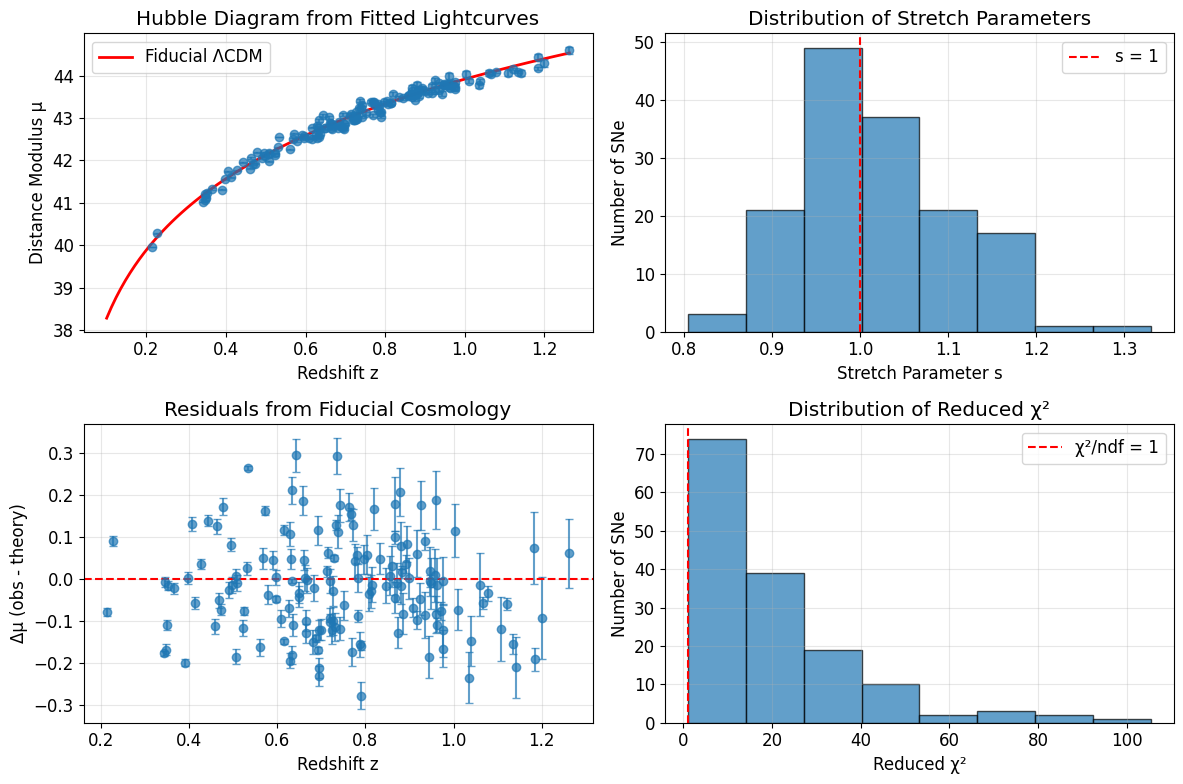


Statistics for 150 fitted supernovae:
Mean stretch parameter: 1.016 ± 0.087
Mean reduced χ²: 20.214 ± 18.677
RMS of residuals: 0.117 mag


In [55]:
# Create Hubble Diagram from fitted distance moduli
if fitting_results:
    # Extract data for plotting
    redshifts_fitted = [r['redshift'] for r in fitting_results]
    mu_fitted = [r['mu'] for r in fitting_results]
    mu_err_fitted = [r['mu_err'] for r in fitting_results]
    stretch_fitted = [r['s'] for r in fitting_results]
    
    # Plot Hubble Diagram
    figure(figsize=(12, 8))
    
    subplot(2, 2, 1)
    errorbar(redshifts_fitted, mu_fitted, yerr=mu_err_fitted, fmt='o', 
             capsize=3, markersize=6, alpha=0.7)
    xlabel('Redshift z')
    ylabel('Distance Modulus μ')
    title('Hubble Diagram from Fitted Lightcurves')
    grid(True, alpha=0.3)
    
    # Compare with theoretical prediction
    z_theory = np.linspace(0.1, max(redshifts_fitted), 100)
    mu_theory = cs.musn1a(z_theory, cosmo_pars)
    plot(z_theory, mu_theory, 'r-', label='Fiducial ΛCDM', linewidth=2)
    legend()
    
    # Plot stretch parameter distribution
    subplot(2, 2, 2)
    hist(stretch_fitted, bins=8, alpha=0.7, edgecolor='black')
    xlabel('Stretch Parameter s')
    ylabel('Number of SNe')
    title('Distribution of Stretch Parameters')
    axvline(1.0, color='red', linestyle='--', label='s = 1')
    legend()
    grid(True, alpha=0.3)
    
    # Plot residuals from fiducial cosmology
    subplot(2, 2, 3)
    mu_theory_at_z = cs.musn1a(np.array(redshifts_fitted), cosmo_pars)
    residuals = np.array(mu_fitted) - mu_theory_at_z
    errorbar(redshifts_fitted, residuals, yerr=mu_err_fitted, fmt='o', 
             capsize=3, markersize=6, alpha=0.7)
    axhline(0, color='red', linestyle='--')
    xlabel('Redshift z')
    ylabel('Δμ (obs - theory)')
    title('Residuals from Fiducial Cosmology')
    grid(True, alpha=0.3)
    
    # Plot χ² distribution
    subplot(2, 2, 4)
    chi2_reduced = [r['chi2_reduced'] for r in fitting_results if np.isfinite(r['chi2_reduced'])]
    hist(chi2_reduced, bins=8, alpha=0.7, edgecolor='black')
    xlabel('Reduced χ²')
    ylabel('Number of SNe')
    title('Distribution of Reduced χ²')
    axvline(1.0, color='red', linestyle='--', label='χ²/ndf = 1')
    legend()
    grid(True, alpha=0.3)
    
    tight_layout()
    show()
    
    # Print statistics
    print(f"\nStatistics for {len(fitting_results)} fitted supernovae:")
    print(f"Mean stretch parameter: {np.mean(stretch_fitted):.3f} ± {np.std(stretch_fitted):.3f}")
    print(f"Mean reduced χ²: {np.mean(chi2_reduced):.3f} ± {np.std(chi2_reduced):.3f}")
    print(f"RMS of residuals: {np.sqrt(np.mean(residuals**2)):.3f} mag")

### Visualisation of the nine first fitting curves

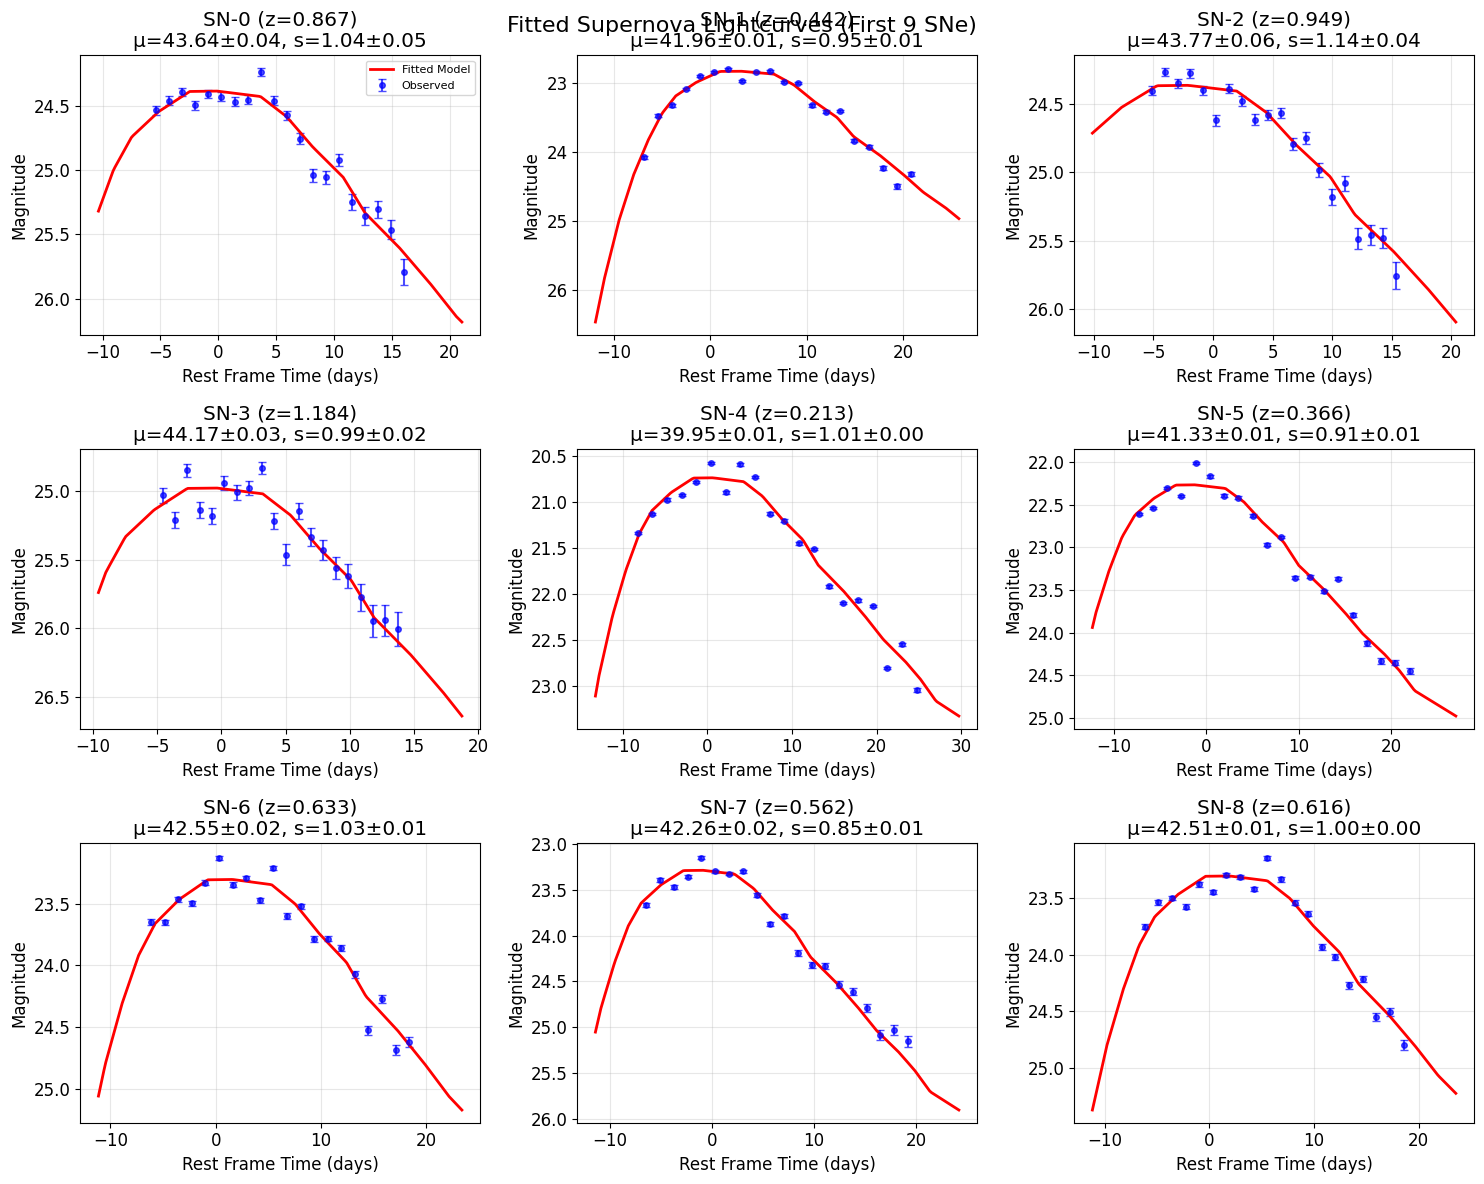


Displayed fitted lightcurves for the first 9 supernovae
Each plot shows:
- Blue points: Observed photometry with error bars
- Red line: Best-fit template lightcurve
- Title includes redshift and fitted parameters (μ, s)


In [45]:
# Plot fitted lightcurves for visualization
if fitting_results:
    # Select a subset of supernovae to plot (first 9 for a 3x3 grid)
    n_plot = min(9, len(fitting_results))
    
    figure(figsize=(15, 12))
    
    for i in range(n_plot):
        result = fitting_results[i]
        sn_number = result['sn_number']
        redshift = result['redshift']
        
        # Load observed data
        filename = f'data/Data-LightCurves/EI2019-Data-LightCurves-SN-{sn_number}_lightcurve.txt'
        if os.path.exists(filename):
            data = np.loadtxt(filename)
            t_obs = data[:, 0]
            mag_obs = data[:, 1]
            mag_err = data[:, 2]
            
            # Convert to rest frame
            t_rest = t_obs / (1 + redshift)
            
            # Generate fitted lightcurve
            t_model = np.linspace(t_rest.min() - 5, t_rest.max() + 5, 200)
            fitted_pars = [result['t0'], result['s'], result['mu']]
            mag_model = lc_template(t_model, fitted_pars)
            
            # Plot in subplot
            subplot(3, 3, i + 1)
            
            # Plot observed data
            errorbar(t_rest, mag_obs, yerr=mag_err, fmt='o', 
                    capsize=3, markersize=4, alpha=0.7, label='Observed', color='blue')
            
            # Plot fitted model
            plot(t_model, mag_model, 'r-', linewidth=2, label='Fitted Model')
            
            # Formatting
            xlabel('Rest Frame Time (days)')
            ylabel('Magnitude')
            title(f'SN-{sn_number} (z={redshift:.3f})\nμ={result["mu"]:.2f}±{result["mu_err"]:.2f}, s={result["s"]:.2f}±{result["s_err"]:.2f}')
            grid(True, alpha=0.3)
            gca().invert_yaxis()  # Invert y-axis for magnitudes (brighter = lower values)
            
            if i == 0:  # Only show legend for first subplot
                legend(loc='upper right', fontsize=8)
    
    tight_layout()
    suptitle('Fitted Supernova Lightcurves (First 9 SNe)', fontsize=16, y=0.98)
    show()
    
    print(f"\nDisplayed fitted lightcurves for the first {n_plot} supernovae")
    print("Each plot shows:")
    print("- Blue points: Observed photometry with error bars")
    print("- Red line: Best-fit template lightcurve")
    print("- Title includes redshift and fitted parameters (μ, s)")

Plotting detailed lightcurve analysis for first 3 supernovae...

=== SN-0 ===


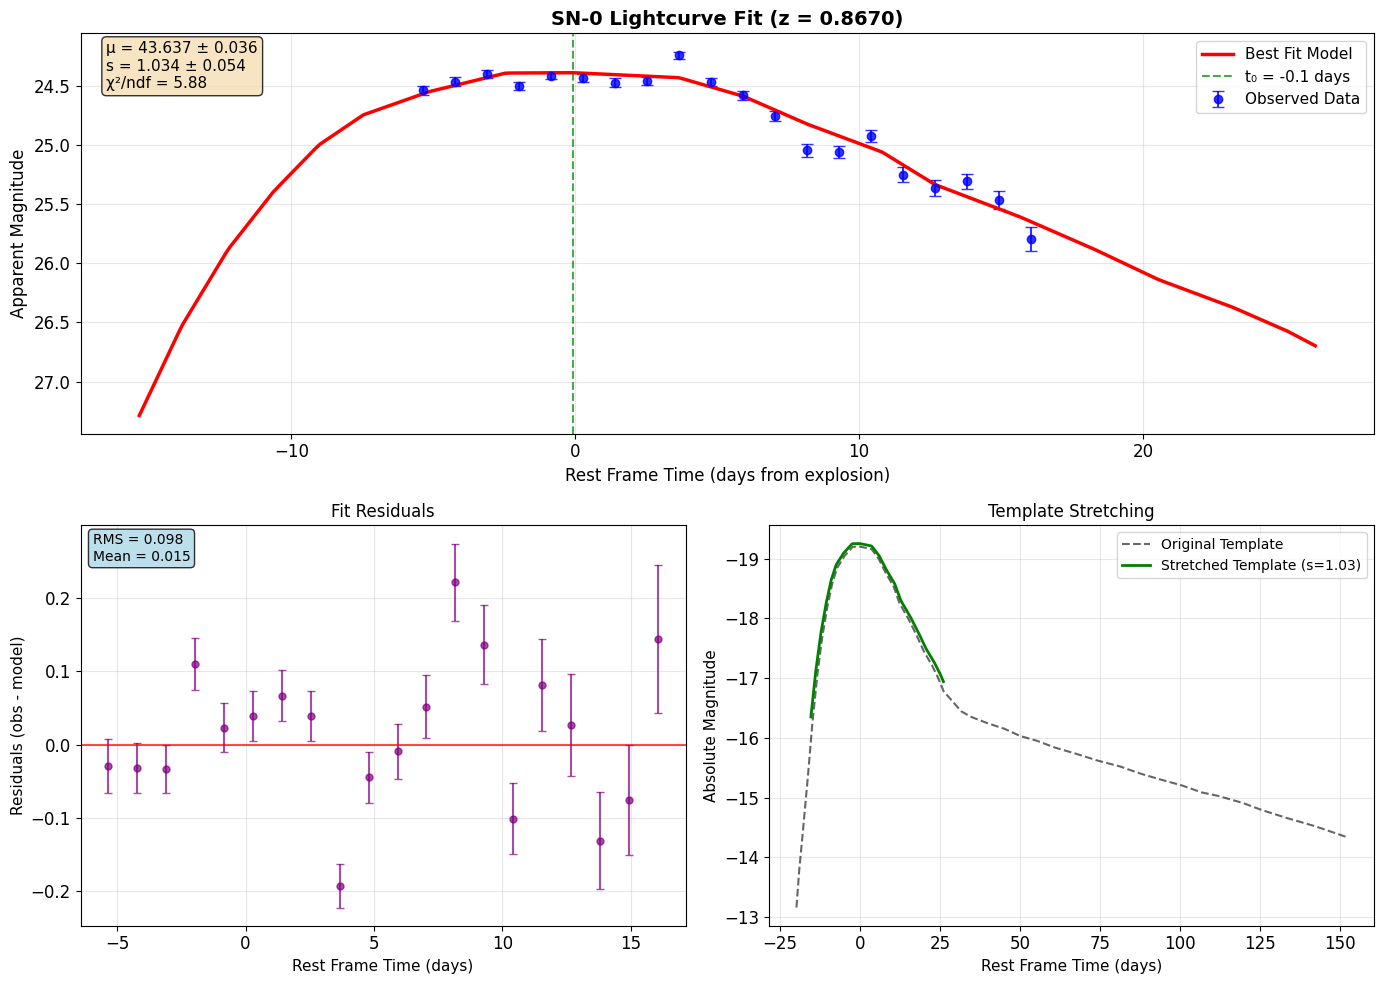


=== SN-1 ===


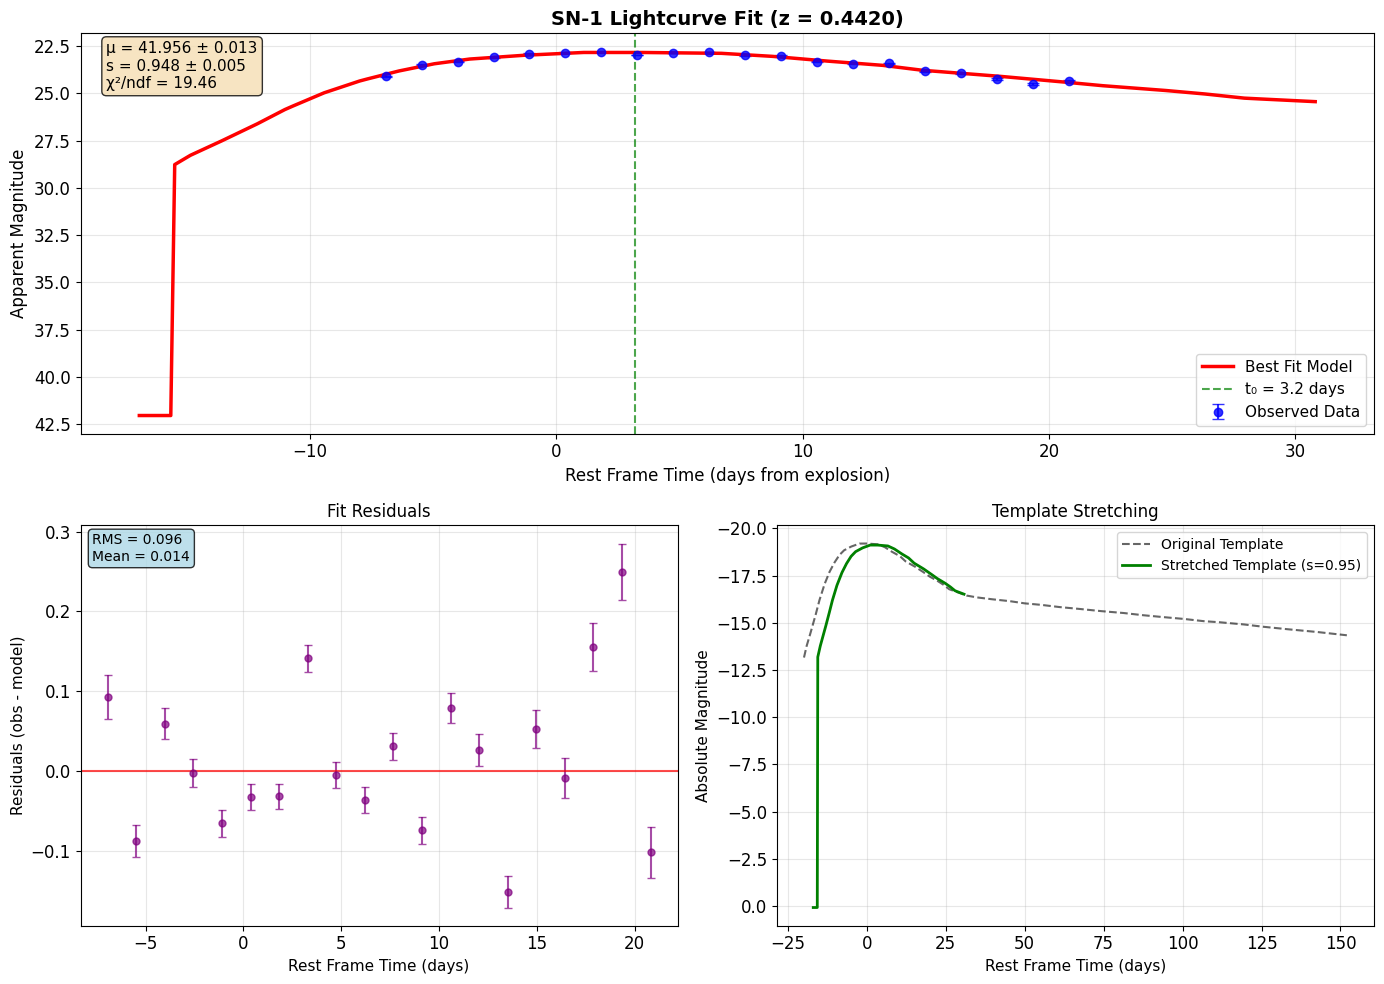


=== SN-2 ===


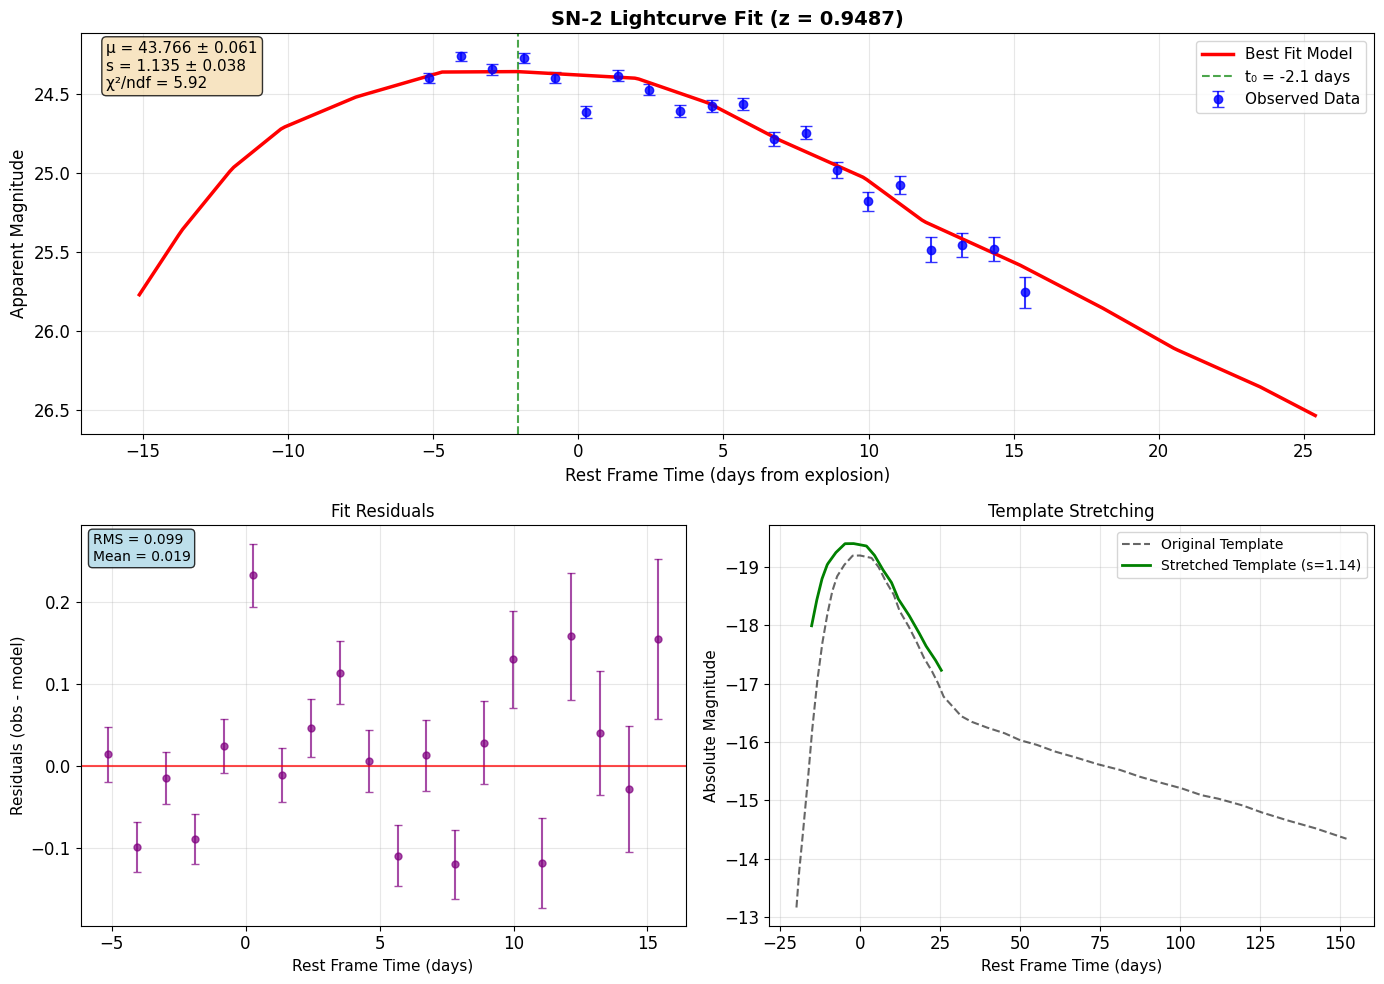

In [ ]:
# Function to plot individual lightcurves with detailed analysis
def plot_detailed_lightcurve(sn_number, result, save_plots=False):
    """
    Plot detailed analysis of a single supernova lightcurve fit
    """
    redshift = result['redshift']
    
    # Load observed data
    filename = f'data/Data-LightCurves/EI2019-Data-LightCurves-SN-{sn_number}_lightcurve.txt'
    if not os.path.exists(filename):
        print(f"Data file not found for SN-{sn_number}")
        return
        
    data = np.loadtxt(filename)
    t_obs = data[:, 0]
    mag_obs = data[:, 1]
    mag_err = data[:, 2]
    
    # Convert to rest frame
    t_rest = t_obs / (1 + redshift)
    
    # Generate fitted lightcurve
    t_model = np.linspace(t_rest.min() - 10, t_rest.max() + 10, 300)
    fitted_pars = [result['t0'], result['s'], result['mu']]
    mag_model = lc_template(t_model, fitted_pars)
    
    # Calculate residuals
    mag_model_at_data = lc_template(t_rest, fitted_pars)
    residuals = mag_obs - mag_model_at_data
    
    # Create detailed plot
    figure(figsize=(14, 10))
    
    # Main lightcurve plot
    subplot(2, 2, (1, 2))
    errorbar(t_rest, mag_obs, yerr=mag_err, fmt='o', 
            capsize=4, markersize=6, alpha=0.8, label='Observed Data', color='blue')
    plot(t_model, mag_model, 'r-', linewidth=2.5, label='Best Fit Model')
    
    # Mark the time of maximum brightness
    axvline(result['t0'], color='green', linestyle='--', alpha=0.7, label=f't₀ = {result["t0"]:.1f} days')
    
    xlabel('Rest Frame Time (days from explosion)', fontsize=12)
    ylabel('Apparent Magnitude', fontsize=12)
    title(f'SN-{sn_number} Lightcurve Fit (z = {redshift:.4f})', fontsize=14, fontweight='bold')
    legend(fontsize=11)
    grid(True, alpha=0.3)
    gca().invert_yaxis()
    
    # Add parameter text box
    textstr = f'μ = {result["mu"]:.3f} ± {result["mu_err"]:.3f}\ns = {result["s"]:.3f} ± {result["s_err"]:.3f}\nχ²/ndf = {result["chi2_reduced"]:.2f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    text(0.02, 0.98, textstr, transform=gca().transAxes, fontsize=11,
         verticalalignment='top', bbox=props)
    
    # Residuals plot
    subplot(2, 2, 3)
    errorbar(t_rest, residuals, yerr=mag_err, fmt='o', 
            capsize=3, markersize=5, alpha=0.7, color='purple')
    axhline(0, color='red', linestyle='-', alpha=0.7)
    xlabel('Rest Frame Time (days)', fontsize=11)
    ylabel('Residuals (obs - model)', fontsize=11)
    title('Fit Residuals', fontsize=12)
    grid(True, alpha=0.3)
    
    # Residual statistics
    rms_residual = np.sqrt(np.mean(residuals**2))
    mean_residual = np.mean(residuals)
    text(0.02, 0.98, f'RMS = {rms_residual:.3f}\nMean = {mean_residual:.3f}', 
         transform=gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    # Template comparison (stretch visualization)
    subplot(2, 2, 4)
    # Plot original template
    plot(t_template, mag_template, 'k--', alpha=0.6, label='Original Template')
    # Plot stretched template at fitted parameters (without distance modulus)
    fitted_pars_no_mu = [result['t0'], result['s'], 0]  # Set mu=0 to show intrinsic shape
    mag_intrinsic = lc_template(t_model, fitted_pars_no_mu)
    plot(t_model, mag_intrinsic, 'g-', linewidth=2, label=f'Stretched Template (s={result["s"]:.2f})')
    
    xlabel('Rest Frame Time (days)', fontsize=11)
    ylabel('Absolute Magnitude', fontsize=11)
    title('Template Stretching', fontsize=12)
    legend(fontsize=10)
    grid(True, alpha=0.3)
    gca().invert_yaxis()
    
    tight_layout()
    
    if save_plots:
        savefig(f'SN_{sn_number}_detailed_fit.png', dpi=300, bbox_inches='tight')
    
    show()

# Plot detailed analysis for first few supernovae
if fitting_results:
    print("Plotting detailed lightcurve analysis for first 3 supernovae...\n")
    for i in range(min(3, len(fitting_results))):
        result = fitting_results[i]
        print(f"=== SN-{result['sn_number']} ===")
        plot_detailed_lightcurve(result['sn_number'], result)
        print()

# Conclusion

- Input : data (150 files of lightcurves [time, magnitude, errors magnitude], 1 file of redshift, 1 file of average lightcurve)

- Output : Lightcurve fitting (for each SN Ia lightcurves, fitting values of the data) and global visualization of results(Hubble diagram, residuals of distance modulus, distribution of stretch parameters and reduced chi²)

### Details :

**Lightcurve Fitting** : We fit individual SN Ia lightcurves using a template-based approach with three parameters:
   - t0 : Time of maximum brightness
   - s : Stretch parameter (brighter-slower effect)
   - μ : Distance modulus

**Physical Effects Accounted For** :
   - **Redshift correction** : Convert observed time to rest frame: t_rest = t_obs / (1 + z)
   - **Brighter-slower relation** : Magnitude correction: -1.52 × (s - 1)
   - **Distance modulus** : The key cosmological parameter we extract

### Key Results Expected :

- **Distance Modulus** : Directly measures luminosity distance to each SN
- **Hubble Diagram** : μ vs z relationship reveals cosmic expansion
- **Stretch Parameters** : Typically s = 1.0 ± 0.3, showing intrinsic SN diversity
- **Cosmological Constraints** : Can constrain H₀, Ωₘ, ΩΛ from the Hubble diagram

### Global analysis :

- Nice fit of the hubble diagram
- Residuals of distance modulus hoghly distributed and arrors bars higher whith the redshift
- Stretch parameter highly distributed around 1
- High Reduced chi² and does not reduced enough rapidly
- Systematic errors not in our data because they are simulated and considered "perfect", then they are only inside of our model and also because we have a lot of zeros for the absolute magnitude for a lot time

### Future :

- Using the results of the MCMC team and then get our chi² less and less high
- Confronting our results with the Work Package CMB 3